# Classification

## Examples

### Basic imports and data load

In [258]:
import matplotlib.pyplot as plt
import random
import os
import urllib
import numpy as np
import pandas as pd
import tarfile
import urllib.request
import email
import email.policy
import re
import nltk
import urlextract
from html import unescape
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,\
            precision_recall_curve, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.ndimage.interpolation import shift
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

C:\Users\basys\AppData\Local\Temp\ipykernel_7988\195714823.py:32: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images.shape

(60000, 28, 28)

In [3]:
train_images = train_images.reshape(60000, 28 * 28)
test_images = test_images.reshape(10000, 28 * 28)
train_images.shape

(60000, 784)

In [4]:
def draw_image(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = "binary")

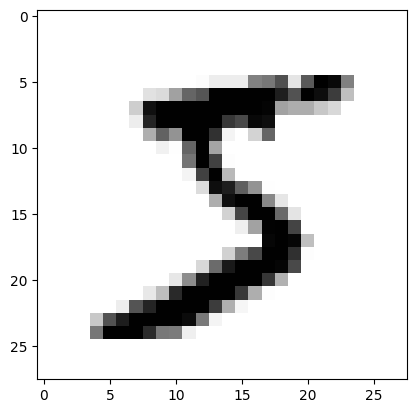

In [5]:
draw_image(train_images[0])

### Binary classification

Consider a specific case, for example if given image is a 5 or not to simplify the problem

In [6]:
y_test_5 = (test_labels == 5)
y_train_5 = (train_labels == 5)

In [7]:
sgd = SGDClassifier()
sgd.fit(train_images, y_train_5)


SGDClassifier()

[False]


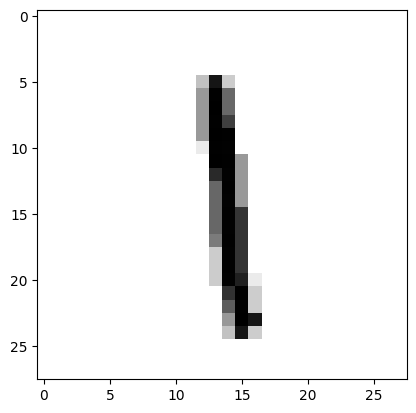

In [8]:
img = random.choice(test_images)
print(sgd.predict(img.reshape(1, -1)))
draw_image(img)

#### Metrics

In [9]:
cross_val_score(sgd, test_images, y_test_5, cv = 3, scoring = "accuracy")

array([0.95140972, 0.96249625, 0.96669667])

In [10]:
y_train_predicted = cross_val_predict(sgd, train_images, y_train_5, cv = 3)

Generally, accuracy is not the best metric as datasets can vary. One should consider confustion matrices

In [11]:
cmatr = confusion_matrix(y_train_5, y_train_predicted)
cmatr

array([[52819,  1760],
       [  813,  4608]])

Confusion matrices follow the following structure (binary case):

| Actual\Predicted | Predicted Positive | Predicted Negative |
|-------------------|--------------------|--------------------|
| Actual Positive   | True Positive (TP) | False Negative (FN) |
| Actual Negative   | False Positive (FP) | True Negative (TN) |

There are other metrics used to check how good the model performs
$$\text{precision} = {TP\over TP + FP}$$
$$\text{recall} = {TP\over TP + FN}$$
$$ F_1 = 2{{\text{recall} \cdot {\text{precision}}\over{\text{recall} + \text{precision}}}}$$

In [12]:
print(f"""recall = {recall_score(y_train_5, y_train_predicted)}  
precision = {precision_score(y_train_5, y_train_predicted)}
f1 = {f1_score(y_train_5, y_train_predicted)}""")

recall = 0.8500276701715551  
precision = 0.7236180904522613
f1 = 0.7817456951395368


Depending on the task, one can be interested in either high accuraccy or recall, so there's a thing called "precision/recall tradeoff", where certain threshold must be chosen, which will impact the classification results

In [13]:
y_scores = cross_val_predict(sgd, train_images, y_train_5, cv = 3, method = "decision_function")

In [14]:
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

(the plot is stolen from the book itself)

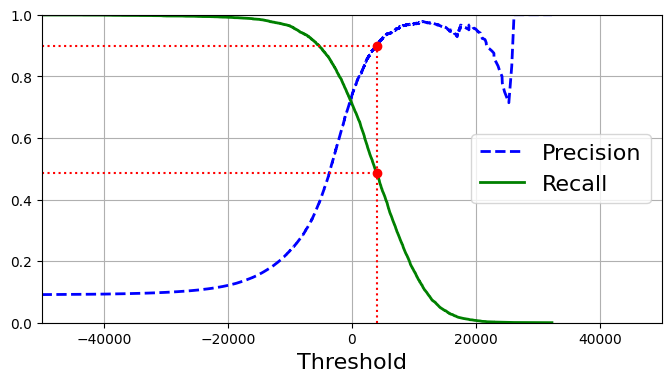

In [15]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recall[np.argmax(precision >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precision >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown

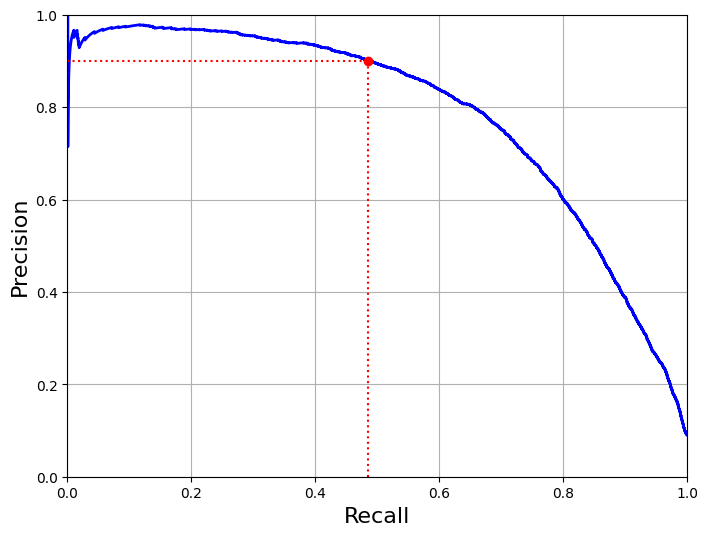

In [16]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precision, recall)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [17]:
idxs = (precision >= 0.90).argmax()
thr_90 = thresholds[idxs]
thr_90

np.float64(4032.0978665594257)

In [18]:
y_train_thr_90 = (y_scores >= thr_90)
print(f""" prec = {precision_score(y_train_5, y_train_thr_90)}
recall = {recall_score(y_train_5, y_train_thr_90)}""")

 prec = 0.9001026342798495
recall = 0.4853348090758163


#### The ROC curve

ROC - receiver operating characteristic curve

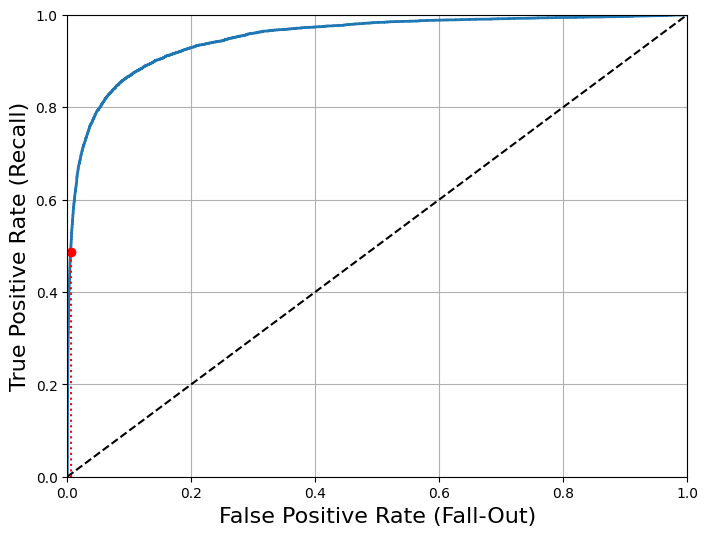

In [19]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

In [20]:
roc_auc_score(y_train_5, y_scores)

np.float64(0.950514072165731)

Consider another classifier and compare it with SGD

In [21]:
forest = RandomForestClassifier()
y_forest = cross_val_predict(forest, train_images, y_train_5, cv = 3, method = "predict_proba")
y_forest[:2]

array([[0.12, 0.88],
       [0.99, 0.01]])

In [22]:
y_forest_scores = y_forest[:, 1]
prec, rec, thr = precision_recall_curve(y_train_5, y_forest_scores)

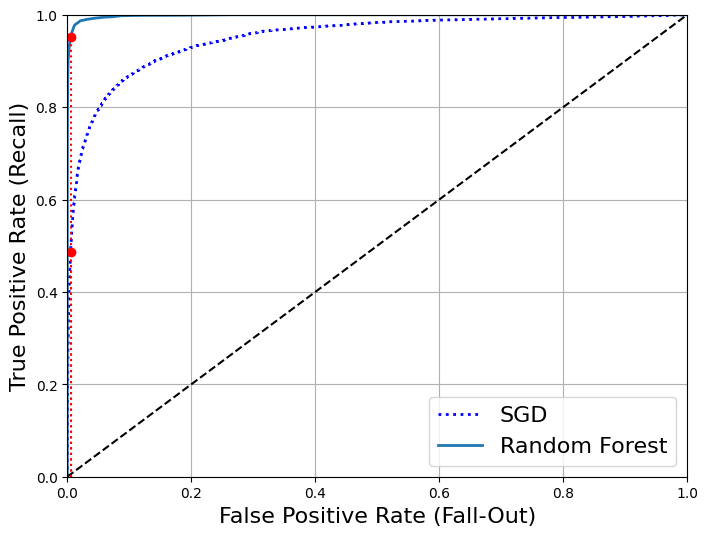

In [23]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_forest_scores)
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
# save_fig("roc_curve_comparison_plot")
plt.show()

### Multiclass classification

In [24]:
svm = SVC()
svm.fit(train_images[:2000], train_labels[:2000])
    

SVC()

[[-0.28844871  7.21235291  9.30443662  6.20863698  0.73119856  1.73387286
   4.78956727  3.80661685  8.28281966  2.78094304]]


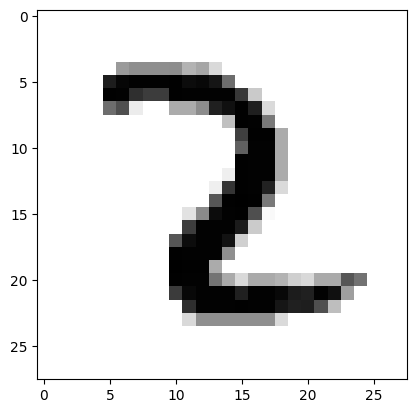

In [25]:
fig = random.choice(train_images).reshape(1, -1)
print(svm.decision_function(fig))
draw_image(fig)

In [26]:
svm.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

One can manually tell scikit to use OvO or OvR

In [27]:
ovr = OneVsRestClassifier(SVC())
ovr.fit(train_images[:2000], train_labels[:2000])

OneVsRestClassifier(estimator=SVC())

[[-2.28985376  1.2373206  -1.21820526 -1.23427983 -1.90020747 -1.79146727
  -1.55342813 -1.39046015 -1.54257501 -1.20911225]]


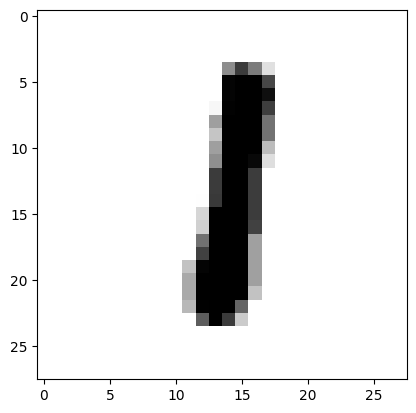

In [28]:
fig = random.choice(train_images).reshape(1, -1)
print(ovr.decision_function(fig))
draw_image(fig)

Previously used SGD classifier can be used for multiclass classification easilly as well.

In [29]:
sgd = SGDClassifier()
sgd.fit(train_images[:2000], train_labels[:2000])

SGDClassifier()

[6]
[[-2989743.52506493 -2953656.52841938 -1244215.90605139 -1735450.52600578
  -3294451.55489426    -9545.21393364  1671654.17856055 -5144762.57402544
  -1523349.90093449  -636417.8300896 ]]


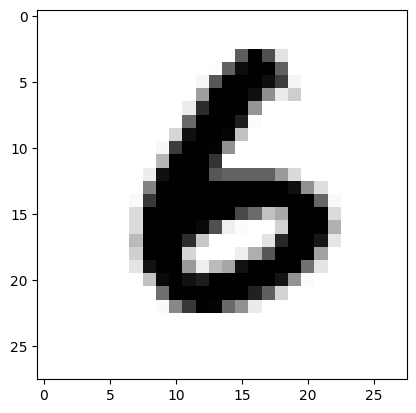

In [30]:
fig = random.choice(train_images).reshape(1, -1)
print(sgd.predict(fig))
print(sgd.decision_function(fig))
draw_image(fig)

In [31]:
cross_val_score(sgd, train_images[:2000], train_labels[:2000], cv = 3, scoring = "accuracy")

array([0.84707646, 0.82158921, 0.86186186])

Norm score :thumbs_up:

Adapting the inputs can increase the score

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_images.astype("float64"))
cross_val_score(sgd, X_train_scaled[:2000], train_labels[:2000], cv=3, scoring="accuracy")

array([0.84557721, 0.82758621, 0.87387387])

### Error analysis

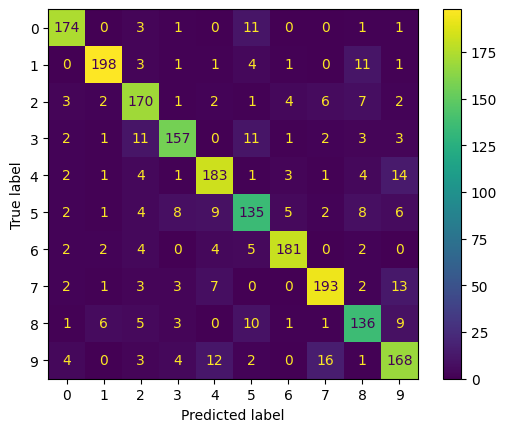

In [33]:
y_train_predicted = cross_val_predict(sgd, X_train_scaled[:2000], train_labels[:2000], cv = 3)
ConfusionMatrixDisplay.from_predictions(train_labels[:2000], y_train_predicted[:2000])

It's better to normalize, because datasets can differ and be imbalanced

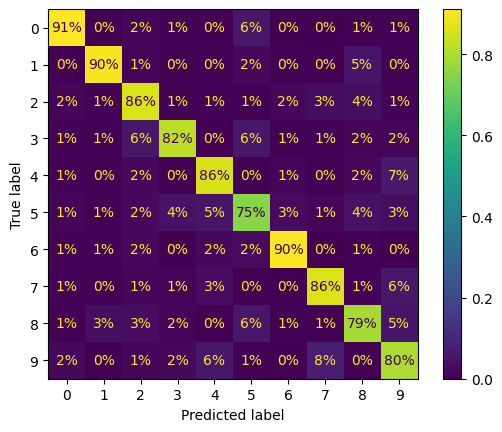

In [34]:
ConfusionMatrixDisplay.from_predictions(train_labels[:2000], y_train_predicted[:2000], normalize="true", values_format=".0%")

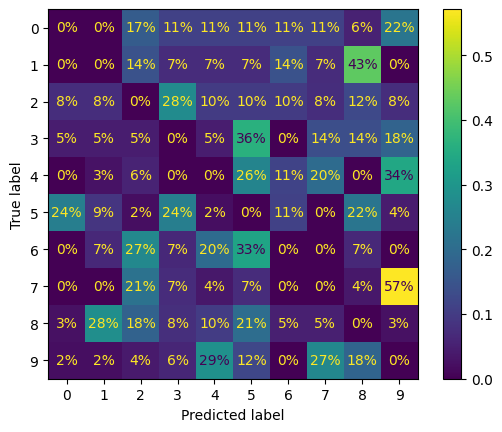

In [35]:
sample_weight = (y_train_predicted[:2000] != train_labels[:2000])
ConfusionMatrixDisplay.from_predictions(y_train_predicted[:2000], train_labels[:2000],
 sample_weight=sample_weight,
 normalize="true", values_format=".0%")

The graph above makes it easier to see what the model misclassifies the most

### Multilabel classification

In [36]:
y_train_large = (train_labels >= 7)
y_train_odd = (train_labels % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn = KNeighborsClassifier()
knn.fit(train_images, y_multilabel)

KNeighborsClassifier()

[[False False]]


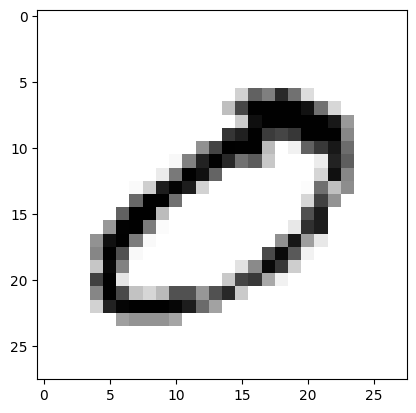

In [37]:
fig = random.choice(train_images).reshape(1, -1)
print(knn.predict(fig))
# print(knn.decision_function(fig))
draw_image(fig)

There are a lot of ways to choose metrics for multilabel classifiers

In [38]:
y_train_knn_pred = cross_val_predict(knn, train_images[:5000], y_multilabel[:5000], cv=3)

In [39]:
f1_score(y_multilabel[:5000], y_train_knn_pred, average="macro")

0.9459349842547329

One can even create a multi-label classifiers for which the classification initially is not supported

In [40]:
chain = ClassifierChain(SVC(), cv = 3)
chain.fit(train_images[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3)

[[1. 1.]]


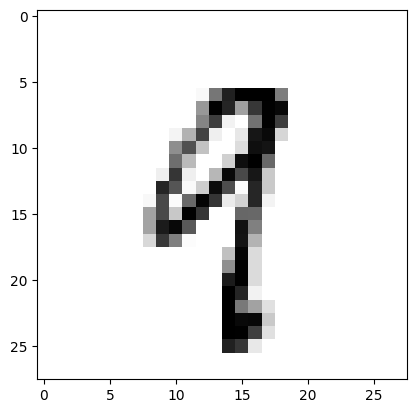

In [41]:
fig = random.choice(train_images).reshape(1, -1)
print(chain.predict(fig))
draw_image(fig)

### Multioutput classification

In [42]:
noise = np.random.randint(0, 100, (len(train_images), 784))
X_train = train_images + noise
noise = np.random.randint(0, 100, (len(test_images), 784))
X_test = test_images + noise

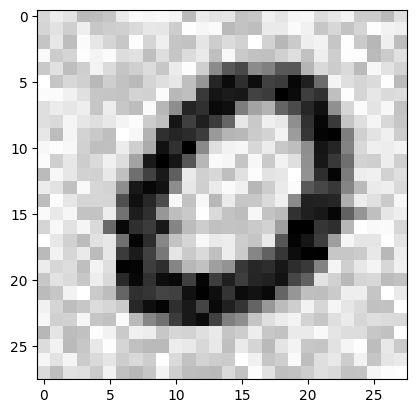

In [43]:
fig = random.choice(X_train)
draw_image(fig)

In [44]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_images)

KNeighborsClassifier()

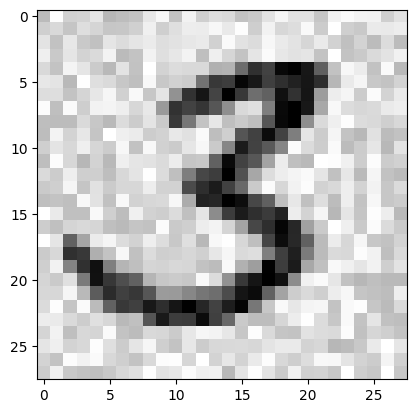

In [45]:
fig = random.choice(X_test)
draw_image(fig)

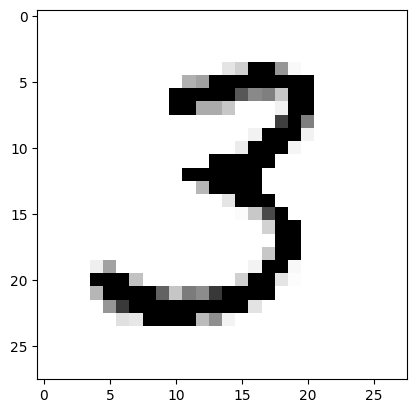

In [46]:
draw_image(knn.predict([fig]))

## Exercises

### 1

In [68]:
knn = KNeighborsClassifier()
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
grid = GridSearchCV(knn, param_grid, cv=3, verbose = 3)
grid.fit(train_images, train_labels)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  18.8s
[CV 2/3] END ....n_neighbors=3, weights=uniform;, score=0.968 total time=  17.7s
[CV 3/3] END ....n_neighbors=3, weights=uniform;, score=0.968 total time=  21.2s
[CV 1/3] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  16.6s
[CV 2/3] END ...n_neighbors=3, weights=distance;, score=0.969 total time=  17.0s
[CV 3/3] END ...n_neighbors=3, weights=distance;, score=0.969 total time=  16.3s
[CV 1/3] END ....n_neighbors=4, weights=uniform;, score=0.966 total time=  19.8s
[CV 2/3] END ....n_neighbors=4, weights=uniform;, score=0.966 total time=  18.1s
[CV 3/3] END ....n_neighbors=4, weights=uniform;, score=0.967 total time=  18.7s
[CV 1/3] END ...n_neighbors=4, weights=distance;, score=0.971 total time=  17.4s
[CV 2/3] END ...n_neighbors=4, weights=distance;, score=0.970 total time=  16.4s
[CV 3/3] END ...n_neighbors=4, weights=distance;,

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [70]:
grid.best_score_

np.float64(0.9703500000000002)

In [72]:
y_pred = grid.predict(test_images)

In [75]:
print(f"""
accuracy {accuracy_score(test_labels, y_pred)}
precision {precision_score(test_labels, y_pred, average = "weighted")}
recall {recall_score(test_labels, y_pred,  average = "weighted")}
""")


accuracy 0.9714
precision 0.9715166824529755
recall 0.9714



### 2

In [109]:
directions = {"left": [0, -1], "right": [0, 1], "up": [-1, 0], "down": [1, 0]}
def shift_image(image, direction):
    if direction not in directions:
        raise ValueError
    image = image.reshape(28, 28)
    return shift(image, directions[direction]).reshape([-1])

In [122]:
X, y = [], []
for img, label in zip(train_images, train_labels):
    X.append(img)
    y.append(label)
    for dir in directions.keys():
        X.append(shift_image(img, dir))
        y.append(label)

In [125]:
X = np.array(X)
y = np.array(y)

In [128]:
knn = KNeighborsClassifier(**grid.best_params_)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [129]:
y_pred = knn.predict(test_images)

In [130]:
print(f"""
accuracy {accuracy_score(test_labels, y_pred)}
precision {precision_score(test_labels, y_pred, average = "weighted")}
recall {recall_score(test_labels, y_pred,  average = "weighted")}
""")


accuracy 0.9763
precision 0.9764262424209593
recall 0.9763



### 3.


In [200]:
TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()   

In [201]:
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [202]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [203]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [204]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [205]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Too much cabin data are null, so one can drop it

In [206]:
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
]
)
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
     ("encoder", OneHotEncoder())
]) 

In [207]:
nums = ["Age", "Fare", "Parch", "SibSp"]
cat = ["Pclass", "Sex", "Embarked"]

total_pipeline = ColumnTransformer([
    ("num", num_pipeline, nums), ("cat", cat_pipeline, cat)
])

In [210]:
X_train = total_pipeline.fit_transform(train_data)
y = train_data["Survived"]

In [211]:
svm = SVC()
svm.fit(X_train, y)

SVC()

In [218]:
X_test = total_pipeline.fit_transform(test_data)

In [219]:
y_pred = svm.predict(X_train)

In [221]:
accuracy_score(y_pred, y)

0.8383838383838383

Gamno! Ne. Norm

### 4.

arhm actuially was doing this part side to side with book's solution cuz toomuchbrainpawatoproccessemails

In [223]:
DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()
fetch_spam_data()

In [224]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [229]:
def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [230]:
ham = [load_email(False, i,) for i in ham_filenames]
spam = [load_email(True, i) for i in spam_filenames]

In [232]:
print(ham[0].get_content())

    Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55

In [233]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [234]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [235]:
structures_counter(ham).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [237]:
for header, value in spam[0].items():
    print(header,"       :        ",value)

Return-Path        :         <12a1mailbot1@web.de>
Delivered-To        :         zzzz@localhost.spamassassin.taint.org
Received        :         from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received        :         from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received        :         from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From        :         12a1mailbot1@web.de
Received        :         from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To        :         dcek1a1@netsgo.com
Subject        :         Life Insurance - Why Pay More?
Date        :         Wed, 21 Aug 2002 20:31

In [239]:
X = np.array(ham + spam, dtype=object)
y = np.array([0] * len(ham) + [1] * len(spam))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [241]:
def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [242]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [243]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [244]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except:
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [245]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [247]:
stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [249]:
url_extractor = urlextract.URLExtract()
print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [251]:
class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [252]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

In [254]:
class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [255]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 20 stored elements and shape (3, 11)>

In [256]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]])

In [257]:
preprocess_pipeline = Pipeline([
    ("email_to_words", EmailToWordCounterTransformer()),
    ("words_to_vector", WordCounterToVectorTransformer()),
])
X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [259]:
log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV] END ................................ score: (test=0.981) total time=   0.0s
[CV] END ................................ score: (test=0.984) total time=   0.0s
[CV] END ................................ score: (test=0.990) total time=   0.0s


np.float64(0.985)

In [260]:
X_test_transformed = preprocess_pipeline.transform(X_test)
log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)
y_pred = log_clf.predict(X_test_transformed)

In [261]:
print(f"""
precision {precision_score(y_pred, y_test)}
recall {recall_score(y_pred, y_test)}
""")


precision 0.9789473684210527
recall 0.96875

